In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from numpy.random import seed
from scipy import stats
from sklearn import preprocessing
import re

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
#Defining MAPE function
def mean_absolute_percentage_error(y_true,y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

In [4]:
# Crea los lags de un df
def lags(dfOriginal, nLag):
    df = dfOriginal.copy()
    for i in df.columns:
        for j in range(1, (nLag+1)):
            palabra = i.split(' ', 1)[0]
            atributo = 'Lag_'+palabra+"_"+str(j)
            df[atributo] = df[i].shift(j)
    
    # Contador para ver cuantos lags hay y así poder eliminar automáticamente los atributos originales
    cont = 0
    for i in df.columns:
        cont = cont + len(re.findall("Lag*", i))
            
    df = df.drop(df.iloc[:, range((len(df.columns)-cont-1))], axis=1) # delete original attributes
    cols = list(df.columns)
    cols = cols[1:] + [cols[0]] 
    df = df[cols]
    
    return df

In [5]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE, testPredMAPE = [], [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagsco2 = np.sum([len(re.findall("Lag_co2*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagsco2], prueba_X_test.iloc[:,-lagsco2:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_co2_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        mape = mean_absolute_percentage_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        testPredMAPE.append(mape)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        print('MAPE %.2f' % (mape))
        
    return testPredRMSE, testPredMAE, testPredMAPE, preds

In [23]:
def testCO2Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.2, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['co2'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, mape, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())

    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel CO2 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de CO2')
    plt.legend()
    plt.show()
    
    return rmse, mae, mape, preds

In [7]:
df = pd.read_csv("21-12-21-datos.csv",
                 sep=";",
                 decimal=",",
                 parse_dates=['time_index'],
                 dayfirst=True,
                 index_col="time_index")

In [8]:
df

,temperature,relativehumidity,pm25,pm10,numberofincoming,numberofoutgoing,co2,ocupacion
time_index,,,,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,68.0,88.0,594.85,0.0
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,186.0,265.0,590.77,0.0
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,354.0,492.0,578.66,0.0
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,80.0,114.0,581.25,0.0
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,467.0,642.0,586.75,0.0
...,...,...,...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,0.0,0.0,409.35,0.0
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,0.0,0.0,408.84,0.0
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,0.0,0.0,408.72,0.0


In [9]:
df = df['2021-10-28']
df

,temperature,relativehumidity,pm25,pm10,numberofincoming,numberofoutgoing,co2,ocupacion
time_index,,,,,,,,
2021-10-28 00:00:00,23.85,53.88,2.00,3.00,0.0,0.0,457.68,0.0
2021-10-28 00:05:00,23.87,53.88,2.29,3.29,0.0,0.0,457.62,0.0
2021-10-28 00:10:00,23.84,53.82,2.43,3.43,0.0,0.0,456.57,0.0
2021-10-28 00:15:00,23.81,53.77,2.00,3.00,0.0,0.0,456.17,0.0
2021-10-28 00:20:00,23.80,53.83,2.00,3.00,0.0,0.0,455.89,0.0
...,...,...,...,...,...,...,...,...
2021-10-28 23:35:00,23.80,54.93,6.86,7.86,0.0,0.0,456.89,0.0
2021-10-28 23:40:00,23.81,54.90,6.62,7.62,0.0,0.0,456.01,0.0
2021-10-28 23:45:00,23.76,54.88,6.50,7.50,0.0,0.0,455.67,0.0


In [10]:
ocupacion = pd.read_csv("ctcount-acces-data-RAW-2020-data.csv",
                 sep=",",
                 decimal=",",
                 parse_dates=['time_index'],
                 dayfirst=True,
                 index_col="time_index")

In [11]:
ocupacion

,endpoint,devicename,numberofincoming,numberofoutgoing
time_index,,,,
2021-09-23 07:06:29,HOPac67b2cd450a,urdecomaq2,2.00,2.00
2021-09-23 07:07:29,HOPac67b2cd450a,urdecomaq2,2.00,2.00
2021-09-23 07:08:29,HOPac67b2cd450a,urdecomaq2,2.00,2.00
2021-09-23 07:09:29,HOPac67b2cd450a,urdecomaq2,2.00,2.00
2021-09-23 07:10:29,HOPac67b2cd450a,urdecomaq2,2.00,2.00
...,...,...,...,...
2022-01-31 23:55:57,HOPac67b2cd450a,urdecomaq2,0.00,0.00
2022-01-31 23:56:57,HOPac67b2cd450a,urdecomaq2,0.00,0.00
2022-01-31 23:57:57,HOPac67b2cd450a,urdecomaq2,0.00,0.00


In [12]:
ocupacion['ocupacion'] = pd.to_numeric(ocupacion['numberofincoming']) - pd.to_numeric(ocupacion['numberofoutgoing'])
ocupacion

,endpoint,devicename,numberofincoming,numberofoutgoing,ocupacion
time_index,,,,,
2021-09-23 07:06:29,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:07:29,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:08:29,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:09:29,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:10:29,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
...,...,...,...,...,...
2022-01-31 23:55:57,HOPac67b2cd450a,urdecomaq2,0.00,0.00,0.0
2022-01-31 23:56:57,HOPac67b2cd450a,urdecomaq2,0.00,0.00,0.0
2022-01-31 23:57:57,HOPac67b2cd450a,urdecomaq2,0.00,0.00,0.0


<AxesSubplot:xlabel='time_index'>

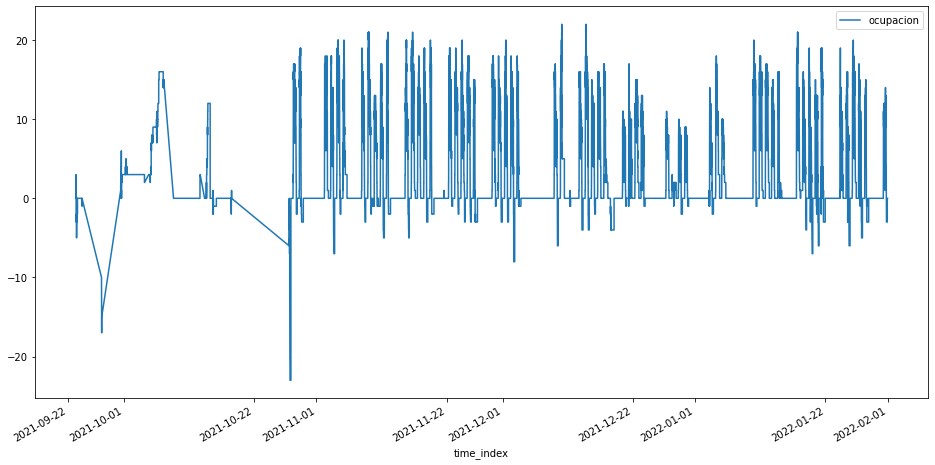

In [39]:
# COGER 28/29 DE OCTUBRE COMO DATOS INICIALES
ocupacion.plot(figsize=(16, 8))

In [13]:
# Para que todos los segundos sean 00
ocupacion = ocupacion.set_index(ocupacion.index.floor('T'), drop=True)

In [14]:
ocupacion['ocupacion'] = pd.to_numeric(ocupacion['numberofincoming']) - pd.to_numeric(ocupacion['numberofoutgoing'])
ocupacion

,endpoint,devicename,numberofincoming,numberofoutgoing,ocupacion
time_index,,,,,
2021-09-23 07:06:00,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:07:00,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:08:00,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:09:00,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:10:00,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
...,...,...,...,...,...
2022-01-31 23:55:00,HOPac67b2cd450a,urdecomaq2,0.00,0.00,0.0
2022-01-31 23:56:00,HOPac67b2cd450a,urdecomaq2,0.00,0.00,0.0
2022-01-31 23:57:00,HOPac67b2cd450a,urdecomaq2,0.00,0.00,0.0


In [29]:
ocupacion.describe()

,ocupacion
count,171318.000000
mean,3.001459
std,5.581391
min,-23.000000
25%,0.000000
50%,0.000000
75%,6.000000
max,22.000000


In [15]:
ocupacion[ocupacion['ocupacion'] < 0]

,endpoint,devicename,numberofincoming,numberofoutgoing,ocupacion
time_index,,,,,
2021-09-23 07:55:00,HOPac67b2cd450a,urdecomaq2,8.00,9.00,-1.0
2021-09-23 07:55:00,HOPac67b2cd450a,urdecomaq2,9.00,10.00,-1.0
2021-09-23 07:55:00,HOPac67b2cd450a,urdecomaq2,9.00,11.00,-2.0
2021-09-23 07:55:00,HOPac67b2cd450a,urdecomaq2,10.00,11.00,-1.0
2021-09-23 07:55:00,HOPac67b2cd450a,urdecomaq2,10.00,12.00,-2.0
...,...,...,...,...,...
2022-01-31 22:56:00,HOPac67b2cd450a,urdecomaq2,90.00,93.00,-3.0
2022-01-31 22:57:00,HOPac67b2cd450a,urdecomaq2,90.00,93.00,-3.0
2022-01-31 22:58:00,HOPac67b2cd450a,urdecomaq2,90.00,93.00,-3.0


In [14]:
# Porcentaje de datos negativos de ocupación
14453/171318*100

8.436358117652553

In [16]:
# Los datos de presencia negativos se ponen a 0
ocupacion[ocupacion['ocupacion'] < 0] = 0

In [17]:
df_final = df[['temperature', 'relativehumidity', 'pm25', 'pm10', 'co2']]
# df_final.reset_index(inplace=True, drop=True)
df_final

,temperature,relativehumidity,pm25,pm10,co2
time_index,,,,,
2021-10-28 00:00:00,23.85,53.88,2.00,3.00,457.68
2021-10-28 00:05:00,23.87,53.88,2.29,3.29,457.62
2021-10-28 00:10:00,23.84,53.82,2.43,3.43,456.57
2021-10-28 00:15:00,23.81,53.77,2.00,3.00,456.17
2021-10-28 00:20:00,23.80,53.83,2.00,3.00,455.89
...,...,...,...,...,...
2021-10-28 23:35:00,23.80,54.93,6.86,7.86,456.89
2021-10-28 23:40:00,23.81,54.90,6.62,7.62,456.01
2021-10-28 23:45:00,23.76,54.88,6.50,7.50,455.67


In [18]:
df_final_ocup = df_final.join(ocupacion['ocupacion'])
df_final_ocup = df_final_ocup[['temperature', 'relativehumidity', 'ocupacion', 'pm25', 'pm10', 'co2']]

In [19]:
# NUMERO DE NA
df_final_ocup['ocupacion'].isna().sum()

0

In [19]:
df_final_ocup.dropna(inplace=True)

# NUMERO DE NA
df_final_ocup['ocupacion'].isna().sum()

0

In [20]:
df_lags_5 = lags(df_final_ocup, 5) #predecir a 5 minutos
df_lags_5 = df_lags_5.iloc[5:,:].reset_index(drop=True)
df_lags_5

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,co2
0,23.80,23.81,23.84,23.87,23.85,53.83,53.77,53.82,53.88,53.88,...,3.00,3.43,3.29,3.00,455.89,456.17,456.57,457.62,457.68,455.26
1,23.80,23.80,23.81,23.84,23.87,53.78,53.83,53.77,53.82,53.88,...,3.00,3.00,3.43,3.29,455.26,455.89,456.17,456.57,457.62,453.98
2,23.74,23.80,23.80,23.81,23.84,53.73,53.78,53.83,53.77,53.82,...,3.00,3.00,3.00,3.43,453.98,455.26,455.89,456.17,456.57,453.58
3,23.71,23.74,23.80,23.80,23.81,53.69,53.73,53.78,53.83,53.77,...,3.00,3.00,3.00,3.00,453.58,453.98,455.26,455.89,456.17,453.01
4,23.73,23.71,23.74,23.80,23.80,53.72,53.69,53.73,53.78,53.83,...,2.86,3.00,3.00,3.00,453.01,453.58,453.98,455.26,455.89,451.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,23.84,23.84,23.85,23.85,23.88,54.84,54.79,54.76,54.69,54.75,...,8.29,8.50,9.00,9.17,456.20,455.95,455.85,456.74,457.30,456.89
320,23.80,23.84,23.84,23.85,23.85,54.93,54.84,54.79,54.76,54.69,...,8.25,8.29,8.50,9.00,456.89,456.20,455.95,455.85,456.74,456.01
321,23.81,23.80,23.84,23.84,23.85,54.90,54.93,54.84,54.79,54.76,...,7.86,8.25,8.29,8.50,456.01,456.89,456.20,455.95,455.85,455.67
322,23.76,23.81,23.80,23.84,23.84,54.88,54.90,54.93,54.84,54.79,...,7.62,7.86,8.25,8.29,455.67,456.01,456.89,456.20,455.95,455.66


In [21]:
df_lags_10 = lags(df_final_ocup, 10) #predecir a 10 minutos
df_lags_10 = df_lags_10.iloc[10:,:].reset_index(drop=True)
df_lags_10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_co2_6,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,co2
0,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,23.85,...,453.01,453.58,453.98,455.26,455.89,456.17,456.57,457.62,457.68,451.02
1,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,...,451.59,453.01,453.58,453.98,455.26,455.89,456.17,456.57,457.62,450.60
2,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,...,451.02,451.59,453.01,453.58,453.98,455.26,455.89,456.17,456.57,450.83
3,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,...,450.60,451.02,451.59,453.01,453.58,453.98,455.26,455.89,456.17,449.44
4,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,...,450.83,450.60,451.02,451.59,453.01,453.58,453.98,455.26,455.89,449.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,455.95,455.85,456.74,457.30,457.95,459.39,459.33,459.07,459.59,456.89
315,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,456.20,455.95,455.85,456.74,457.30,457.95,459.39,459.33,459.07,456.01
316,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,456.89,456.20,455.95,455.85,456.74,457.30,457.95,459.39,459.33,455.67
317,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,456.01,456.89,456.20,455.95,455.85,456.74,457.30,457.95,459.39,455.66


In [22]:
df_lags_15 = lags(df_final_ocup, 15) #predecir a 15 minutos
df_lags_15 = df_lags_15.iloc[15:,:].reset_index(drop=True)
df_lags_15

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,Lag_co2_11,Lag_co2_12,Lag_co2_13,Lag_co2_14,Lag_co2_15,co2
0,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,...,453.01,453.58,453.98,455.26,455.89,456.17,456.57,457.62,457.68,449.43
1,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,...,451.59,453.01,453.58,453.98,455.26,455.89,456.17,456.57,457.62,449.01
2,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,...,451.02,451.59,453.01,453.58,453.98,455.26,455.89,456.17,456.57,448.22
3,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,...,450.60,451.02,451.59,453.01,453.58,453.98,455.26,455.89,456.17,448.05
4,23.58,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,...,450.83,450.60,451.02,451.59,453.01,453.58,453.98,455.26,455.89,447.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,459.39,459.33,459.07,459.59,460.81,461.43,462.09,462.75,463.05,456.89
310,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,457.95,459.39,459.33,459.07,459.59,460.81,461.43,462.09,462.75,456.01
311,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,457.30,457.95,459.39,459.33,459.07,459.59,460.81,461.43,462.09,455.67
312,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,456.74,457.30,457.95,459.39,459.33,459.07,459.59,460.81,461.43,455.66


# Linear Regression

## 5 minutos

Test Score Step 1
RMSE 13.92
MAE 10.82
MAPE 8.55
Test Score Step 2
RMSE 21.26
MAE 16.92
MAPE 8.87
Test Score Step 3
RMSE 28.61
MAE 22.85
MAPE 9.26
Test Score Step 4
RMSE 36.31
MAE 29.00
MAPE 9.77
Test Score Step 5
RMSE 43.70
MAE 34.86
MAPE 10.37


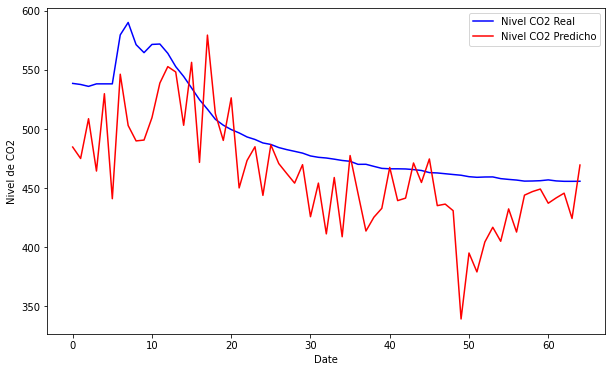

In [25]:
rmse_5, mae_5, mape_5, preds_5 = testCO2Quality(df_lags_5, 5, LinearRegression())

## 10 minutos

Test Score Step 1
RMSE 19.22
MAE 15.40
MAPE 8.70
Test Score Step 2
RMSE 28.95
MAE 23.74
MAPE 9.23
Test Score Step 3
RMSE 37.17
MAE 30.72
MAPE 9.82
Test Score Step 4
RMSE 44.28
MAE 36.68
MAPE 10.46
Test Score Step 5
RMSE 51.77
MAE 42.72
MAPE 11.21
Test Score Step 6
RMSE 61.40
MAE 50.50
MAPE 12.32
Test Score Step 7
RMSE 68.83
MAE 56.52
MAPE 13.32
Test Score Step 8
RMSE 75.94
MAE 62.28
MAPE 14.30
Test Score Step 9
RMSE 81.47
MAE 66.82
MAPE 15.09
Test Score Step 10
RMSE 86.20
MAE 70.65
MAPE 15.80


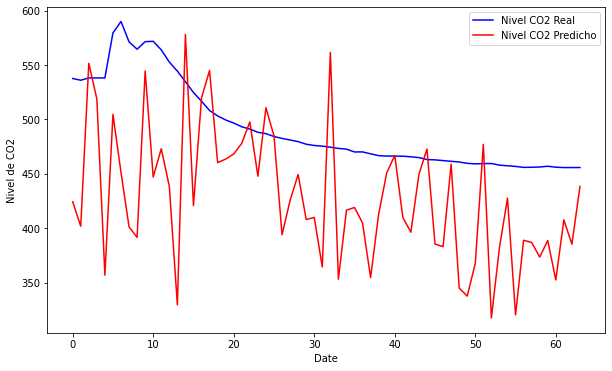

In [26]:
rmse_10, mae_10, mape_10, preds_10 = testCO2Quality(df_lags_10, 10, LinearRegression())

## 15 minutos

Test Score Step 1
RMSE 32.47
MAE 27.95
MAPE 9.46
Test Score Step 2
RMSE 48.65
MAE 42.36
MAPE 11.00
Test Score Step 3
RMSE 61.22
MAE 53.45
MAPE 12.53
Test Score Step 4
RMSE 71.05
MAE 61.93
MAPE 13.92
Test Score Step 5
RMSE 79.84
MAE 69.62
MAPE 15.22
Test Score Step 6
RMSE 92.95
MAE 81.01
MAPE 17.22
Test Score Step 7
RMSE 101.95
MAE 88.75
MAPE 18.66
Test Score Step 8
RMSE 109.66
MAE 95.30
MAPE 19.98
Test Score Step 9
RMSE 113.96
MAE 99.02
MAPE 20.73
Test Score Step 10
RMSE 115.64
MAE 100.50
MAPE 21.03
Test Score Step 11
RMSE 115.71
MAE 100.63
MAPE 21.05
Test Score Step 12
RMSE 117.04
MAE 101.85
MAPE 21.27
Test Score Step 13
RMSE 118.11
MAE 102.80
MAPE 21.45
Test Score Step 14
RMSE 119.49
MAE 103.97
MAPE 21.70
Test Score Step 15
RMSE 120.32
MAE 104.69
MAPE 21.86


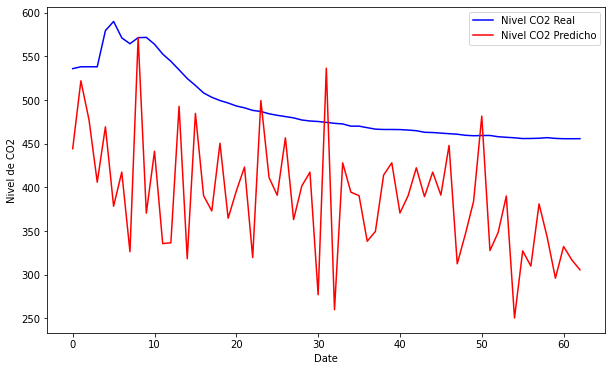

In [28]:
rmse_15, mae_15, mape_10, preds_15 = testCO2Quality(df_lags_15, 15, LinearRegression())

# Random Forest

Test Score Step 1
RMSE 10.94
MAE 7.93
MAPE 8.69
Test Score Step 2
RMSE 12.44
MAE 9.00
MAPE 8.73
Test Score Step 3
RMSE 12.87
MAE 9.34
MAPE 8.77
Test Score Step 4
RMSE 13.43
MAE 9.78
MAPE 8.81
Test Score Step 5
RMSE 13.87
MAE 10.03
MAPE 8.86


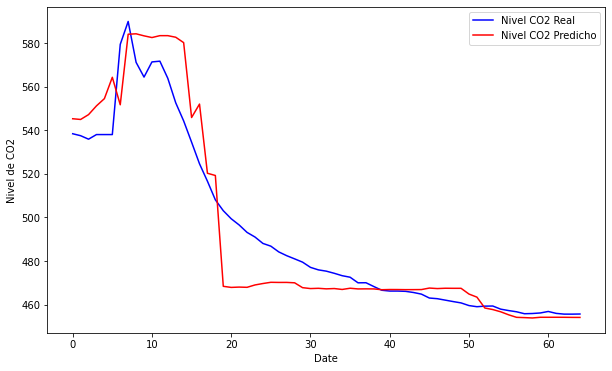

In [29]:
rmse_rf_5, mae_rf_5, mape_rf_5, preds_rf_5 = testCO2Quality(df_lags_5, 5, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 13.22
MAE 9.37
MAPE 8.70
Test Score Step 2
RMSE 14.73
MAE 10.28
MAPE 8.80
Test Score Step 3
RMSE 16.47
MAE 11.32
MAPE 8.92
Test Score Step 4
RMSE 18.07
MAE 12.15
MAPE 9.01
Test Score Step 5
RMSE 18.71
MAE 12.54
MAPE 9.08
Test Score Step 6
RMSE 19.63
MAE 13.05
MAPE 9.16
Test Score Step 7
RMSE 20.00
MAE 13.50
MAPE 9.14
Test Score Step 8
RMSE 20.18
MAE 13.68
MAPE 9.15
Test Score Step 9
RMSE 20.26
MAE 13.77
MAPE 9.15
Test Score Step 10
RMSE 20.29
MAE 13.88
MAPE 9.14


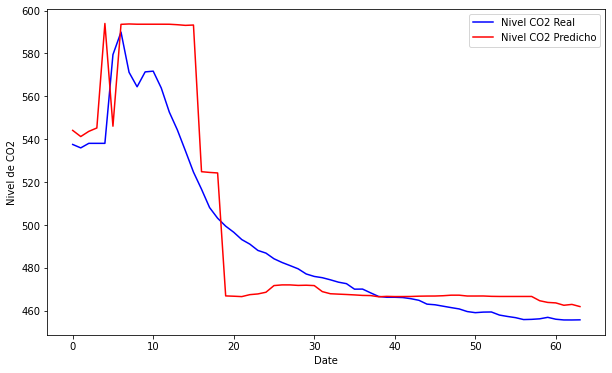

In [30]:
rmse_rf_10, mae_rf_10, mape_rf_10, preds_rf_10 = testCO2Quality(df_lags_10, 10, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 15.78
MAE 11.51
MAPE 8.88
Test Score Step 2
RMSE 18.14
MAE 12.76
MAPE 9.11
Test Score Step 3
RMSE 19.11
MAE 13.20
MAPE 9.24
Test Score Step 4
RMSE 19.73
MAE 13.60
MAPE 9.30
Test Score Step 5
RMSE 20.11
MAE 13.92
MAPE 9.37
Test Score Step 6
RMSE 20.24
MAE 14.00
MAPE 9.39
Test Score Step 7
RMSE 20.35
MAE 14.14
MAPE 9.39
Test Score Step 8
RMSE 20.39
MAE 14.19
MAPE 9.39
Test Score Step 9
RMSE 20.32
MAE 14.16
MAPE 9.39
Test Score Step 10
RMSE 20.20
MAE 14.13
MAPE 9.38
Test Score Step 11
RMSE 20.22
MAE 14.15
MAPE 9.39
Test Score Step 12
RMSE 20.33
MAE 14.22
MAPE 9.40
Test Score Step 13
RMSE 20.35
MAE 14.22
MAPE 9.40
Test Score Step 14
RMSE 20.37
MAE 14.26
MAPE 9.40
Test Score Step 15
RMSE 20.38
MAE 14.27
MAPE 9.40


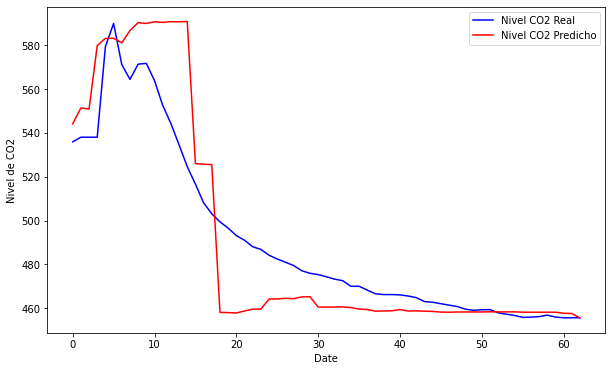

In [31]:
rmse_rf_15, mae_rf_15, mape_rf_15, preds_rf_15 = testCO2Quality(df_lags_15, 15, RandomForestRegressor(random_state=seed_value))

# PM2.5

In [32]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE, testPredMAPE = [], [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagspm25 = np.sum([len(re.findall("Lag_pm25*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagspm25], prueba_X_test.iloc[:,-lagspm25:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_pm25_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        mape = mean_absolute_percentage_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        testPredMAPE.append(mape)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        print('MAPE %.2f' % (mape))
        
    return testPredRMSE, testPredMAE, testPredMAPE, preds

In [33]:
def testPM25Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.2, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['pm25'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, mape, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel PM2.5 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel PM2.5 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de PM2.5')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [34]:
df_final_pm25 = df_final_ocup[['temperature', 'relativehumidity', 'ocupacion', 'pm10', 'co2', 'pm25']]

In [35]:
df_lags_5_pm25 = lags(df_final_pm25, 5) #predecir a 5 minutos
df_lags_5_pm25 = df_lags_5_pm25.iloc[5:,:].reset_index(drop=True)
df_lags_5_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm25_1,Lag_pm25_2,Lag_pm25_3,Lag_pm25_4,Lag_pm25_5,pm25
0,23.80,23.81,23.84,23.87,23.85,53.83,53.77,53.82,53.88,53.88,...,456.17,456.57,457.62,457.68,2.00,2.00,2.43,2.29,2.00,2.00
1,23.80,23.80,23.81,23.84,23.87,53.78,53.83,53.77,53.82,53.88,...,455.89,456.17,456.57,457.62,2.00,2.00,2.00,2.43,2.29,2.00
2,23.74,23.80,23.80,23.81,23.84,53.73,53.78,53.83,53.77,53.82,...,455.26,455.89,456.17,456.57,2.00,2.00,2.00,2.00,2.43,1.86
3,23.71,23.74,23.80,23.80,23.81,53.69,53.73,53.78,53.83,53.77,...,453.98,455.26,455.89,456.17,1.86,2.00,2.00,2.00,2.00,2.12
4,23.73,23.71,23.74,23.80,23.80,53.72,53.69,53.73,53.78,53.83,...,453.58,453.98,455.26,455.89,2.12,1.86,2.00,2.00,2.00,1.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,23.84,23.84,23.85,23.85,23.88,54.84,54.79,54.76,54.69,54.75,...,455.95,455.85,456.74,457.30,7.25,7.29,7.50,8.00,8.17,6.86
320,23.80,23.84,23.84,23.85,23.85,54.93,54.84,54.79,54.76,54.69,...,456.20,455.95,455.85,456.74,6.86,7.25,7.29,7.50,8.00,6.62
321,23.81,23.80,23.84,23.84,23.85,54.90,54.93,54.84,54.79,54.76,...,456.89,456.20,455.95,455.85,6.62,6.86,7.25,7.29,7.50,6.50
322,23.76,23.81,23.80,23.84,23.84,54.88,54.90,54.93,54.84,54.79,...,456.01,456.89,456.20,455.95,6.50,6.62,6.86,7.25,7.29,6.86


In [36]:
df_lags_10_pm25 = lags(df_final_pm25, 10) #predecir a 10 minutos
df_lags_10_pm25 = df_lags_10_pm25.iloc[10:,:].reset_index(drop=True)
df_lags_10_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm25_2,Lag_pm25_3,Lag_pm25_4,Lag_pm25_5,Lag_pm25_6,Lag_pm25_7,Lag_pm25_8,Lag_pm25_9,Lag_pm25_10,pm25
0,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,23.85,...,2.12,1.86,2.00,2.00,2.00,2.00,2.43,2.29,2.00,1.86
1,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,...,1.62,2.12,1.86,2.00,2.00,2.00,2.00,2.43,2.29,1.75
2,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,...,1.86,1.62,2.12,1.86,2.00,2.00,2.00,2.00,2.43,1.75
3,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,...,1.75,1.86,1.62,2.12,1.86,2.00,2.00,2.00,2.00,1.43
4,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,...,1.75,1.75,1.86,1.62,2.12,1.86,2.00,2.00,2.00,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,7.29,7.50,8.00,8.17,8.62,9.33,10.00,9.88,10.43,6.86
315,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,7.25,7.29,7.50,8.00,8.17,8.62,9.33,10.00,9.88,6.62
316,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,6.86,7.25,7.29,7.50,8.00,8.17,8.62,9.33,10.00,6.50
317,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,6.62,6.86,7.25,7.29,7.50,8.00,8.17,8.62,9.33,6.86


In [37]:
df_lags_15_pm25 = lags(df_final_pm25, 15) #predecir a 15 minutos
df_lags_15_pm25 = df_lags_15_pm25.iloc[15:,:].reset_index(drop=True)
df_lags_15_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm25_7,Lag_pm25_8,Lag_pm25_9,Lag_pm25_10,Lag_pm25_11,Lag_pm25_12,Lag_pm25_13,Lag_pm25_14,Lag_pm25_15,pm25
0,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,...,2.12,1.86,2.00,2.00,2.00,2.00,2.43,2.29,2.00,1.57
1,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,...,1.62,2.12,1.86,2.00,2.00,2.00,2.00,2.43,2.29,1.38
2,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,...,1.86,1.62,2.12,1.86,2.00,2.00,2.00,2.00,2.43,1.50
3,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,...,1.75,1.86,1.62,2.12,1.86,2.00,2.00,2.00,2.00,1.71
4,23.58,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,...,1.75,1.75,1.86,1.62,2.12,1.86,2.00,2.00,2.00,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,9.33,10.00,9.88,10.43,10.12,9.88,9.57,7.88,6.88,6.86
310,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,8.62,9.33,10.00,9.88,10.43,10.12,9.88,9.57,7.88,6.62
311,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,8.17,8.62,9.33,10.00,9.88,10.43,10.12,9.88,9.57,6.50
312,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,8.00,8.17,8.62,9.33,10.00,9.88,10.43,10.12,9.88,6.86


## Linear Regression

Test Score Step 1
RMSE 0.64
MAE 0.46
MAPE 48.84
Test Score Step 2
RMSE 0.63
MAE 0.46
MAPE 48.86
Test Score Step 3
RMSE 0.64
MAE 0.47
MAPE 48.85
Test Score Step 4
RMSE 0.65
MAE 0.47
MAPE 48.83
Test Score Step 5
RMSE 0.65
MAE 0.48
MAPE 48.82


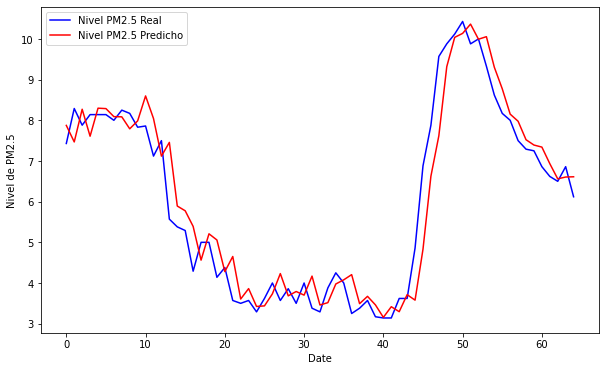

In [38]:
rmse_lr_5_pm25, mae_lr_5_pm25, preds_lr_5_pm25 = testPM25Quality(df_lags_5_pm25, 5, LinearRegression())

Test Score Step 1
RMSE 0.85
MAE 0.67
MAPE 46.60
Test Score Step 2
RMSE 0.90
MAE 0.74
MAPE 46.34
Test Score Step 3
RMSE 0.96
MAE 0.80
MAPE 46.04
Test Score Step 4
RMSE 1.00
MAE 0.84
MAPE 45.69
Test Score Step 5
RMSE 1.02
MAE 0.86
MAPE 45.36
Test Score Step 6
RMSE 1.03
MAE 0.88
MAPE 45.07
Test Score Step 7
RMSE 1.05
MAE 0.89
MAPE 44.79
Test Score Step 8
RMSE 1.05
MAE 0.89
MAPE 44.61
Test Score Step 9
RMSE 1.05
MAE 0.88
MAPE 44.47
Test Score Step 10
RMSE 1.04
MAE 0.86
MAPE 44.41


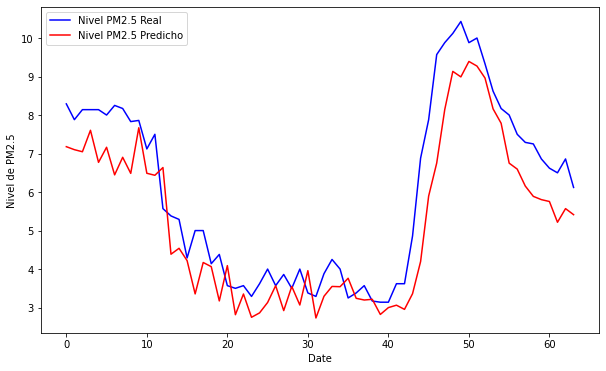

In [39]:
rmse_lr_10_pm25, mae_lr_10_pm25, preds_lr_10_pm25 = testPM25Quality(df_lags_10_pm25, 10, LinearRegression())

Test Score Step 1
RMSE 0.76
MAE 0.57
MAPE 47.54
Test Score Step 2
RMSE 0.78
MAE 0.60
MAPE 47.34
Test Score Step 3
RMSE 0.80
MAE 0.62
MAPE 47.08
Test Score Step 4
RMSE 0.82
MAE 0.65
MAPE 46.82
Test Score Step 5
RMSE 0.84
MAE 0.66
MAPE 46.51
Test Score Step 6
RMSE 0.85
MAE 0.68
MAPE 46.25
Test Score Step 7
RMSE 0.86
MAE 0.68
MAPE 46.01
Test Score Step 8
RMSE 0.87
MAE 0.68
MAPE 45.86
Test Score Step 9
RMSE 0.86
MAE 0.67
MAPE 45.69
Test Score Step 10
RMSE 0.85
MAE 0.66
MAPE 45.56
Test Score Step 11
RMSE 0.86
MAE 0.66
MAPE 45.43
Test Score Step 12
RMSE 0.87
MAE 0.66
MAPE 45.39
Test Score Step 13
RMSE 0.87
MAE 0.66
MAPE 45.35
Test Score Step 14
RMSE 0.86
MAE 0.65
MAPE 45.36
Test Score Step 15
RMSE 0.86
MAE 0.64
MAPE 45.37


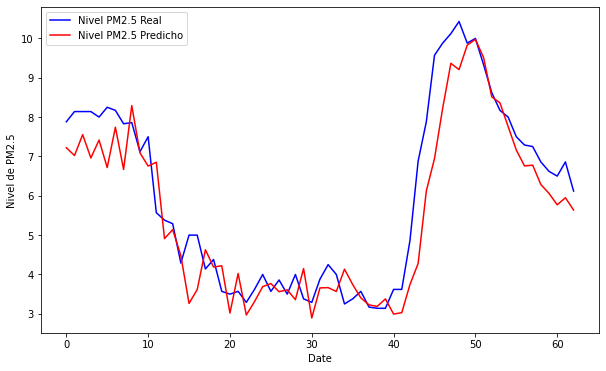

In [40]:
rmse_lr_15_pm25, mae_lr_15_pm25, preds_lr_15_pm25 = testPM25Quality(df_lags_15_pm25, 15, LinearRegression())

## Random Forest

Test Score Step 1
RMSE 1.19
MAE 0.97
MAPE 42.41
Test Score Step 2
RMSE 1.25
MAE 1.04
MAPE 42.70
Test Score Step 3
RMSE 1.26
MAE 1.06
MAPE 42.78
Test Score Step 4
RMSE 1.26
MAE 1.06
MAPE 42.81
Test Score Step 5
RMSE 1.27
MAE 1.06
MAPE 42.82


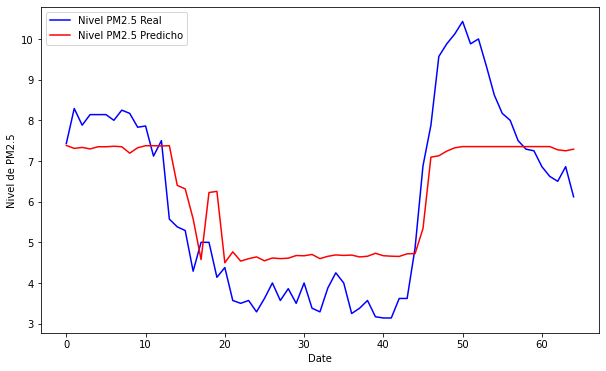

In [41]:
rmse_rf_5_pm25, mae_rf_5_pm25, preds_rf_5_pm25 = testPM25Quality(df_lags_5_pm25, 5, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 1.22
MAE 0.99
MAPE 42.41
Test Score Step 2
RMSE 1.22
MAE 0.99
MAPE 42.47
Test Score Step 3
RMSE 1.22
MAE 0.99
MAPE 42.50
Test Score Step 4
RMSE 1.21
MAE 0.98
MAPE 42.52
Test Score Step 5
RMSE 1.21
MAE 0.98
MAPE 42.53
Test Score Step 6
RMSE 1.22
MAE 0.99
MAPE 42.53
Test Score Step 7
RMSE 1.22
MAE 0.99
MAPE 42.53
Test Score Step 8
RMSE 1.21
MAE 0.98
MAPE 42.51
Test Score Step 9
RMSE 1.22
MAE 0.99
MAPE 42.52
Test Score Step 10
RMSE 1.21
MAE 0.98
MAPE 42.50


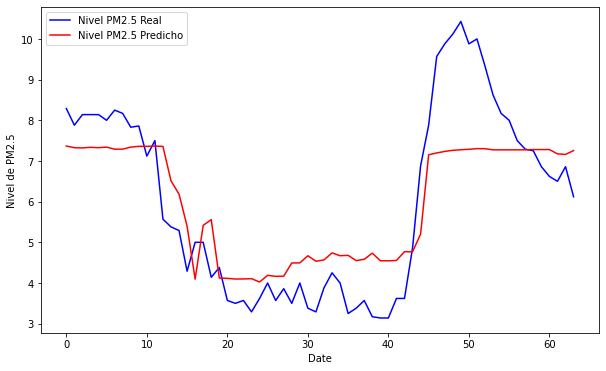

In [42]:
rmse_rf_10_pm25, mae_rf_10_pm25, preds_rf_10_pm25 = testPM25Quality(df_lags_10_pm25, 10, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 1.29
MAE 1.06
MAPE 45.05
Test Score Step 2
RMSE 1.36
MAE 1.12
MAPE 45.43
Test Score Step 3
RMSE 1.36
MAE 1.12
MAPE 45.46
Test Score Step 4
RMSE 1.36
MAE 1.12
MAPE 45.52
Test Score Step 5
RMSE 1.37
MAE 1.13
MAPE 45.59
Test Score Step 6
RMSE 1.38
MAE 1.14
MAPE 45.60
Test Score Step 7
RMSE 1.38
MAE 1.14
MAPE 45.61
Test Score Step 8
RMSE 1.38
MAE 1.15
MAPE 45.61
Test Score Step 9
RMSE 1.39
MAE 1.15
MAPE 45.60
Test Score Step 10
RMSE 1.39
MAE 1.15
MAPE 45.59
Test Score Step 11
RMSE 1.39
MAE 1.15
MAPE 45.59
Test Score Step 12
RMSE 1.39
MAE 1.15
MAPE 45.59
Test Score Step 13
RMSE 1.39
MAE 1.15
MAPE 45.59
Test Score Step 14
RMSE 1.39
MAE 1.15
MAPE 45.59
Test Score Step 15
RMSE 1.38
MAE 1.15
MAPE 45.56


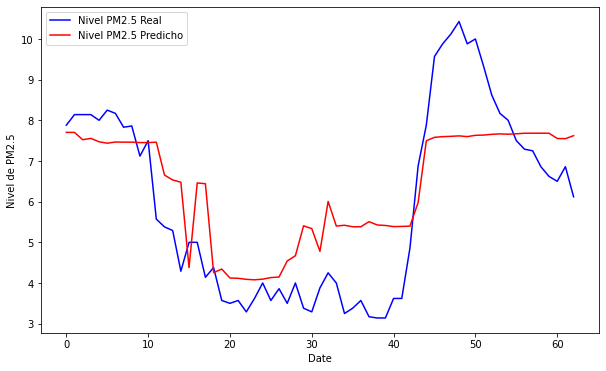

In [43]:
rmse_rf_15_pm25, mae_rf_15_pm25, preds_rf_15_pm25 = testPM25Quality(df_lags_15_pm25, 15, RandomForestRegressor(random_state=seed_value))

# PM10

In [44]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE, testPredMAPE = [], [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagspm10 = np.sum([len(re.findall("Lag_pm10*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagspm10], prueba_X_test.iloc[:,-lagspm10:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_pm10_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        mape = mean_absolute_percentage_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        testPredMAPE.append(mape)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        print('MAE %.2f' % (mape))
        
    return testPredRMSE, testPredMAE, testPredMAPE, preds

In [45]:
def testPM10Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.2, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['pm10'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, mape, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel PM10 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel PM10 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de PM10')
    plt.legend()
    plt.show()
    
    return rmse, mae, mape, preds

In [46]:
df_final_pm10 = df_final_ocup[['temperature', 'relativehumidity', 'ocupacion', 'pm25', 'co2', 'pm10']]

In [47]:
df_lags_5_pm10 = lags(df_final_pm10, 5) #predecir a 5 minutos
df_lags_5_pm10 = df_lags_5_pm10.iloc[5:,:].reset_index(drop=True)
df_lags_5_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm10_1,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,pm10
0,23.80,23.81,23.84,23.87,23.85,53.83,53.77,53.82,53.88,53.88,...,456.17,456.57,457.62,457.68,3.00,3.00,3.43,3.29,3.00,3.00
1,23.80,23.80,23.81,23.84,23.87,53.78,53.83,53.77,53.82,53.88,...,455.89,456.17,456.57,457.62,3.00,3.00,3.00,3.43,3.29,3.00
2,23.74,23.80,23.80,23.81,23.84,53.73,53.78,53.83,53.77,53.82,...,455.26,455.89,456.17,456.57,3.00,3.00,3.00,3.00,3.43,2.86
3,23.71,23.74,23.80,23.80,23.81,53.69,53.73,53.78,53.83,53.77,...,453.98,455.26,455.89,456.17,2.86,3.00,3.00,3.00,3.00,3.12
4,23.73,23.71,23.74,23.80,23.80,53.72,53.69,53.73,53.78,53.83,...,453.58,453.98,455.26,455.89,3.12,2.86,3.00,3.00,3.00,2.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,23.84,23.84,23.85,23.85,23.88,54.84,54.79,54.76,54.69,54.75,...,455.95,455.85,456.74,457.30,8.25,8.29,8.50,9.00,9.17,7.86
320,23.80,23.84,23.84,23.85,23.85,54.93,54.84,54.79,54.76,54.69,...,456.20,455.95,455.85,456.74,7.86,8.25,8.29,8.50,9.00,7.62
321,23.81,23.80,23.84,23.84,23.85,54.90,54.93,54.84,54.79,54.76,...,456.89,456.20,455.95,455.85,7.62,7.86,8.25,8.29,8.50,7.50
322,23.76,23.81,23.80,23.84,23.84,54.88,54.90,54.93,54.84,54.79,...,456.01,456.89,456.20,455.95,7.50,7.62,7.86,8.25,8.29,7.86


In [48]:
df_lags_10_pm10 = lags(df_final_pm10, 10) #predecir a 10 minutos
df_lags_10_pm10 = df_lags_10_pm10.iloc[10:,:].reset_index(drop=True)
df_lags_10_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_pm10_6,Lag_pm10_7,Lag_pm10_8,Lag_pm10_9,Lag_pm10_10,pm10
0,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,23.85,...,3.12,2.86,3.00,3.00,3.00,3.00,3.43,3.29,3.00,2.86
1,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,...,2.62,3.12,2.86,3.00,3.00,3.00,3.00,3.43,3.29,2.75
2,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,...,2.86,2.62,3.12,2.86,3.00,3.00,3.00,3.00,3.43,2.75
3,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,...,2.75,2.86,2.62,3.12,2.86,3.00,3.00,3.00,3.00,2.43
4,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,...,2.75,2.75,2.86,2.62,3.12,2.86,3.00,3.00,3.00,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,8.29,8.50,9.00,9.17,9.62,10.33,11.00,10.88,11.43,7.86
315,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,8.25,8.29,8.50,9.00,9.17,9.62,10.33,11.00,10.88,7.62
316,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,7.86,8.25,8.29,8.50,9.00,9.17,9.62,10.33,11.00,7.50
317,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,7.62,7.86,8.25,8.29,8.50,9.00,9.17,9.62,10.33,7.86


In [49]:
df_lags_15_pm10 = lags(df_final_pm10, 15) #predecir a 15 minutos
df_lags_15_pm10 = df_lags_15_pm10.iloc[15:,:].reset_index(drop=True)
df_lags_15_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm10_7,Lag_pm10_8,Lag_pm10_9,Lag_pm10_10,Lag_pm10_11,Lag_pm10_12,Lag_pm10_13,Lag_pm10_14,Lag_pm10_15,pm10
0,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,...,3.12,2.86,3.00,3.00,3.00,3.00,3.43,3.29,3.00,2.57
1,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,...,2.62,3.12,2.86,3.00,3.00,3.00,3.00,3.43,3.29,2.38
2,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,...,2.86,2.62,3.12,2.86,3.00,3.00,3.00,3.00,3.43,2.50
3,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,...,2.75,2.86,2.62,3.12,2.86,3.00,3.00,3.00,3.00,2.71
4,23.58,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,...,2.75,2.75,2.86,2.62,3.12,2.86,3.00,3.00,3.00,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,10.33,11.00,10.88,11.43,11.12,10.88,10.57,8.88,7.88,7.86
310,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,9.62,10.33,11.00,10.88,11.43,11.12,10.88,10.57,8.88,7.62
311,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,9.17,9.62,10.33,11.00,10.88,11.43,11.12,10.88,10.57,7.50
312,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,9.00,9.17,9.62,10.33,11.00,10.88,11.43,11.12,10.88,7.86


## Linear Regression

Test Score Step 1
RMSE 0.64
MAE 0.46
MAE 40.11
Test Score Step 2
RMSE 0.63
MAE 0.46
MAE 40.12
Test Score Step 3
RMSE 0.64
MAE 0.47
MAE 40.11
Test Score Step 4
RMSE 0.65
MAE 0.47
MAE 40.09
Test Score Step 5
RMSE 0.65
MAE 0.48
MAE 40.08


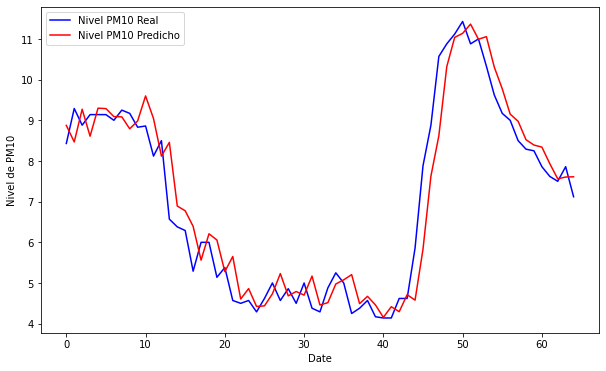

In [50]:
rmse_lr_5_pm10, mae_lr_5_pm10, mape_lr_5_pm10, preds_lr_5_pm10 = testPM10Quality(df_lags_5_pm10, 5, LinearRegression())

Test Score Step 1
RMSE 0.85
MAE 0.67
MAE 38.63
Test Score Step 2
RMSE 0.90
MAE 0.74
MAE 38.47
Test Score Step 3
RMSE 0.96
MAE 0.80
MAE 38.26
Test Score Step 4
RMSE 1.00
MAE 0.84
MAE 38.00
Test Score Step 5
RMSE 1.02
MAE 0.86
MAE 37.74
Test Score Step 6
RMSE 1.03
MAE 0.88
MAE 37.50
Test Score Step 7
RMSE 1.05
MAE 0.89
MAE 37.28
Test Score Step 8
RMSE 1.05
MAE 0.89
MAE 37.12
Test Score Step 9
RMSE 1.05
MAE 0.88
MAE 37.00
Test Score Step 10
RMSE 1.04
MAE 0.86
MAE 36.94


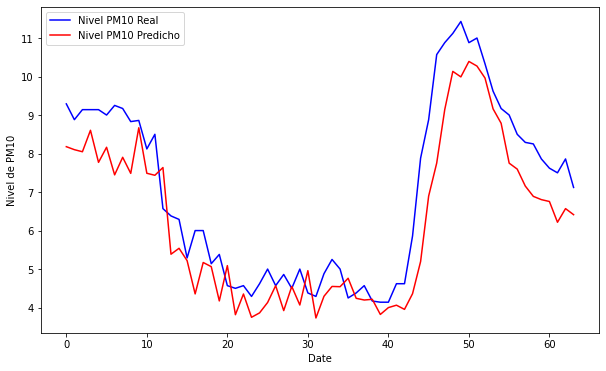

In [51]:
rmse_lr_10_pm10, mae_lr_10_pm10, mape_lr_10_pm10, preds_lr_10_pm10 = testPM10Quality(df_lags_10_pm10, 10, LinearRegression())

Test Score Step 1
RMSE 0.76
MAE 0.57
MAE 39.27
Test Score Step 2
RMSE 0.78
MAE 0.60
MAE 39.13
Test Score Step 3
RMSE 0.80
MAE 0.62
MAE 38.94
Test Score Step 4
RMSE 0.82
MAE 0.65
MAE 38.75
Test Score Step 5
RMSE 0.84
MAE 0.66
MAE 38.50
Test Score Step 6
RMSE 0.85
MAE 0.68
MAE 38.29
Test Score Step 7
RMSE 0.86
MAE 0.68
MAE 38.09
Test Score Step 8
RMSE 0.87
MAE 0.68
MAE 37.97
Test Score Step 9
RMSE 0.86
MAE 0.67
MAE 37.82
Test Score Step 10
RMSE 0.85
MAE 0.66
MAE 37.71
Test Score Step 11
RMSE 0.86
MAE 0.66
MAE 37.60
Test Score Step 12
RMSE 0.87
MAE 0.66
MAE 37.56
Test Score Step 13
RMSE 0.87
MAE 0.66
MAE 37.53
Test Score Step 14
RMSE 0.86
MAE 0.65
MAE 37.53
Test Score Step 15
RMSE 0.86
MAE 0.64
MAE 37.53


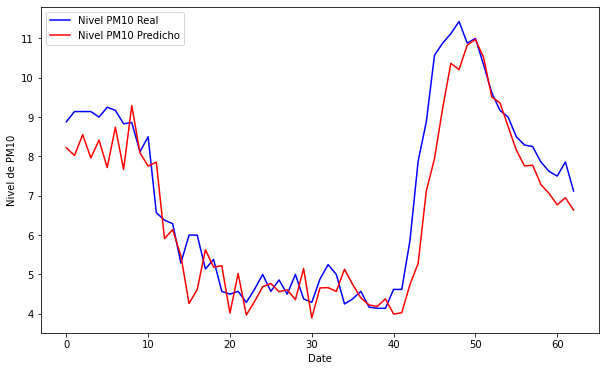

In [52]:
rmse_lr_15_pm10, mae_lr_15_pm10, mape_lr_15_pm10, preds_lr_15_pm10 = testPM10Quality(df_lags_15_pm10, 15, LinearRegression())

## Random Forest

Test Score Step 1
RMSE 1.23
MAE 1.00
MAE 34.95
Test Score Step 2
RMSE 1.25
MAE 1.04
MAE 35.04
Test Score Step 3
RMSE 1.27
MAE 1.06
MAE 35.10
Test Score Step 4
RMSE 1.28
MAE 1.07
MAE 35.13
Test Score Step 5
RMSE 1.28
MAE 1.07
MAE 35.15


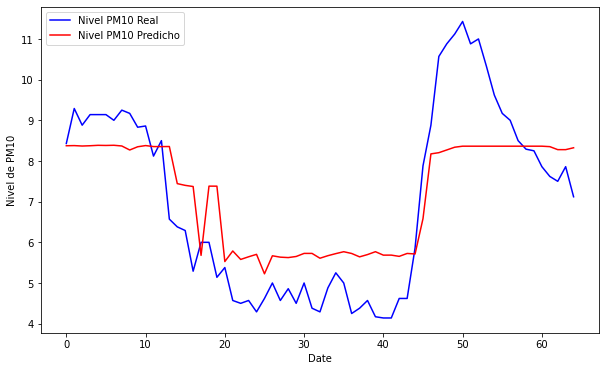

In [53]:
rmse_rf_5_pm10, mae_rf_5_pm10, mape_rf_5_pm10, preds_rf_5_pm10 = testPM10Quality(df_lags_5_pm10, 5, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 1.24
MAE 1.01
MAE 34.99
Test Score Step 2
RMSE 1.24
MAE 1.02
MAE 35.05
Test Score Step 3
RMSE 1.24
MAE 1.01
MAE 35.08
Test Score Step 4
RMSE 1.23
MAE 1.01
MAE 35.10
Test Score Step 5
RMSE 1.24
MAE 1.01
MAE 35.11
Test Score Step 6
RMSE 1.24
MAE 1.01
MAE 35.12
Test Score Step 7
RMSE 1.24
MAE 1.02
MAE 35.13
Test Score Step 8
RMSE 1.24
MAE 1.02
MAE 35.13
Test Score Step 9
RMSE 1.25
MAE 1.02
MAE 35.13
Test Score Step 10
RMSE 1.24
MAE 1.02
MAE 35.12


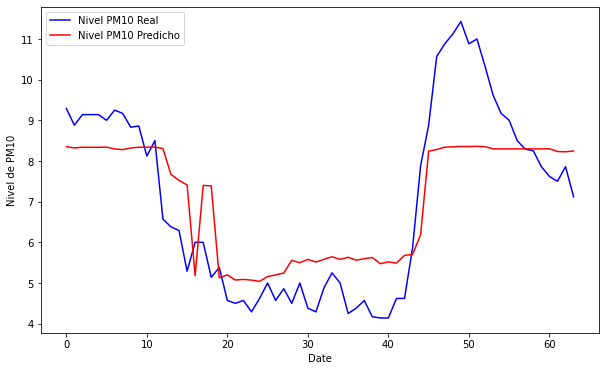

In [54]:
rmse_rf_10_pm10, mae_rf_10_pm10, mape_rf_10_pm10, preds_rf_10_pm10 = testPM10Quality(df_lags_10_pm10, 10, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 1.30
MAE 1.08
MAE 37.02
Test Score Step 2
RMSE 1.40
MAE 1.16
MAE 37.39
Test Score Step 3
RMSE 1.43
MAE 1.18
MAE 37.57
Test Score Step 4
RMSE 1.51
MAE 1.24
MAE 37.83
Test Score Step 5
RMSE 1.56
MAE 1.28
MAE 38.01
Test Score Step 6
RMSE 1.59
MAE 1.30
MAE 38.12
Test Score Step 7
RMSE 1.60
MAE 1.31
MAE 38.16
Test Score Step 8
RMSE 1.60
MAE 1.31
MAE 38.17
Test Score Step 9
RMSE 1.60
MAE 1.32
MAE 38.19
Test Score Step 10
RMSE 1.60
MAE 1.32
MAE 38.19
Test Score Step 11
RMSE 1.60
MAE 1.32
MAE 38.21
Test Score Step 12
RMSE 1.61
MAE 1.33
MAE 38.21
Test Score Step 13
RMSE 1.60
MAE 1.32
MAE 38.19
Test Score Step 14
RMSE 1.61
MAE 1.33
MAE 38.21
Test Score Step 15
RMSE 1.59
MAE 1.31
MAE 38.15


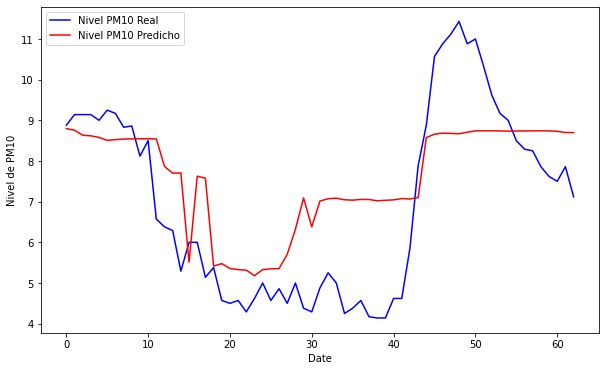

In [55]:
rmse_rf_15_pm10, mae_rf_15_pm10, mape_rf_15_pm10, preds_rf_15_pm10 = testPM10Quality(df_lags_15_pm10, 15, RandomForestRegressor(random_state=seed_value))